# DATA201 - Project 2

Please use this page http://apps.ecs.vuw.ac.nz/submit/DATA201 for submitssion and submit only this single Jupyter notebook with your code added into it at the appropriate places.

The due date is **Friday 7th June, before midnight**.

The dataset for this assignment are files **loan_train.csv** and **loan_test.csv** which are provided with this notebook.

Please choose menu items *Kernel => Restart & Run All* then *File => Save and Checkpoint* in Jupyter before submission.

## Problem Statement

A company deals in all home loans. They have presence across all urban, semi urban and rural areas.
Customers first apply for home loan after that company validates the customer eligibility for loan.

The company wants to automate the loan eligibility process (in real-time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers.

## Data

| Variable	            | Description                                     |
|-----------------------|-------------------------------------------------|
|``Loan_ID``            |Unique Loan ID                                   |
|``Gender``             |Male / Female                                    |
|``Married``            |Applicant married (Y/N)                          |
|``Dependents``         |Number of dependents                             |
|``Education``          |Applicant Education (Graduate / Under Graduate)  |
|``Self_Employed``      |Self employed (Y/N)                              |
|``ApplicantIncome``    |Applicant income                                 |
|``CoapplicantIncome``  |Coapplicant income                               |
|``LoanAmount``         |Loan amount in thousands                         |
|``Loan_Amount_Term``   |Term of loan in months                           |
|``Credit_History``     |Credit history meets guidelines                  |
|``Property_Area``      |Urban / Semi Urban / Rural                       |
|``Loan_Status``        |Loan approved (Y/N)                              |

Use ``loan_train.csv`` to build a model to predict if a loan application is approved (``Loan_Status`` is the label), and test the model using ``loan_test.csv``. 

## Model Evaluation

Use AUC (area under the receiver operating characteristic curve) as the evaluation metric.

## Guidelines

- This is an End-to-End machine learning project. Please review lecture notes in weeks 6 and 7 carefully before starting the project.
- This is also an *open* project. There is no restriction in using any algorithms or packages, even those which are not discussed in the lectures.
- The followings are expected in this project (**maximum possible points: 15++**):
    + Exploratory analysis and visualisation [**2 points**]
    + Data preparation (outliers and missing values treatment, feature selection, feature engineering, feature scaling, etc. - not all of those steps are required) [**3 points**]
    + Model training (train many quick models, measure and compare their performance, analyze important features and types of errors, ... then short-list the top 3 to 5 most promising models, preferring models that make different types of errors) [**4 points**]
    + Model tuning (fine-tune the hyper-parameters using cross-validation, try ensemble methods, ... then measure the final model's performance on the test set) [**5 points**]
    + Present your solution (present interesting points you noticed along the way (what worked and what did not, your assumptions and your systems limitations), communicate your key findings through beautiful visualizations or easy-to-remember statements, etc.) [**1 point**]
- Bonus points (maximum **2 points**): for those who obtain the highest AUC value on the test set and for those who automate the steps above as much as possible.

In [931]:
import numpy               as np
import pandas              as pd
import matplotlib          as mpl
import matplotlib.pyplot   as plt
from pandas.plotting       import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from   sklearn.neighbors       import KNeighborsClassifier
from   sklearn.metrics         import accuracy_score, confusion_matrix
from   sklearn.model_selection import GridSearchCV, RandomizedSearchCV



%matplotlib inline

### Data Loading

Load the training data set and test data set from .csv files as two DataFrames.

In [932]:
df_train = pd.read_csv('loan_train.csv')
df_test  = pd.read_csv('loan_test.csv')

### 1. Exploratory Data Analysis

Take a look at the top 3 rows of training set and test set.

In [933]:
df_train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban,Y
1,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban,Y
2,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural,N


In [934]:
df_test.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001528,Male,No,0,Graduate,No,6277,0.0,118.0,360.0,0.0,Rural,N
1,LP002804,Female,Yes,0,Graduate,No,4180,2306.0,182.0,360.0,1.0,Semiurban,Y
2,LP002945,Male,Yes,0,Graduate,Yes,9963,0.0,180.0,360.0,1.0,Rural,Y


#### Data Sets Dimension Check

In [935]:
print("There are " + str(df_train.shape[0]) + " rows and " + str(df_train.shape[1]) + " columns of data in train set;")
print("There are " + str(df_test.shape[0])  + " rows and " + str(df_test.shape[1])  + " columns of data in test set;")
print("Train set takes %.2f%%, test set takes %.2f%%." 
      % (df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]) * 100,
         df_test.shape[0]  / (df_train.shape[0] + df_test.shape[0]) * 100))

There are 491 rows and 13 columns of data in train set;
There are 123 rows and 13 columns of data in test set;
Train set takes 79.97%, test set takes 20.03%.


#### Attributes & Missing Data Check

In [936]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 13 columns):
Loan_ID              491 non-null object
Gender               480 non-null object
Married              488 non-null object
Dependents           483 non-null object
Education            491 non-null object
Self_Employed        464 non-null object
ApplicantIncome      491 non-null int64
CoapplicantIncome    491 non-null float64
LoanAmount           471 non-null float64
Loan_Amount_Term     479 non-null float64
Credit_History       448 non-null float64
Property_Area        491 non-null object
Loan_Status          491 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 49.9+ KB


In [937]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 13 columns):
Loan_ID              123 non-null object
Gender               121 non-null object
Married              123 non-null object
Dependents           116 non-null object
Education            123 non-null object
Self_Employed        118 non-null object
ApplicantIncome      123 non-null int64
CoapplicantIncome    123 non-null float64
LoanAmount           121 non-null float64
Loan_Amount_Term     121 non-null float64
Credit_History       116 non-null float64
Property_Area        123 non-null object
Loan_Status          123 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 12.6+ KB


In [938]:
print("There are 491 instances in train set, 123 instances in test set.")
print("Missing data are found in 7 out of 13 features in train set, 6 out 13 features in test set.")
print("Apart from 5 numerical features, the dtype of 8 features are object.")
print("After looking through the data sets, they should be categorical attributes.")

There are 491 instances in train set, 123 instances in test set.
Missing data are found in 7 out of 13 features in train set, 6 out 13 features in test set.
Apart from 5 numerical features, the dtype of 8 features are object.
After looking through the data sets, they should be categorical attributes.


#### Categorical Attributes Exploration

In [939]:
print("1. Gender in Train Set & Test Set")
print(df_train["Gender"].value_counts())
print(df_test["Gender"].value_counts())
print("==========")
print("2. Married in Train Set & Test Set")
print(df_train["Married"].value_counts())
print(df_test["Married"].value_counts())
print("==========")
print("3. Dependents in Train Set & Test Set")
print(df_train["Dependents"].value_counts())
print(df_test["Dependents"].value_counts())
print("==========")
print("4. Education in Train Set & Test Set")
print(df_train["Education"].value_counts())
print(df_test["Education"].value_counts())
print("==========")
print("5. Self_Employed in Train Set & Test Set")
print(df_train["Self_Employed"].value_counts())
print(df_test["Self_Employed"].value_counts())
print("==========")
print("6. Property_Area in Train Set & Test Set")
print(df_train["Property_Area"].value_counts())
print(df_test["Property_Area"].value_counts())
print("==========")
print("7. Loan_Status in Train Set & Test Set")
print(df_train["Loan_Status"].value_counts())
print(df_test["Loan_Status"].value_counts())

1. Gender in Train Set & Test Set
Male      393
Female     87
Name: Gender, dtype: int64
Male      96
Female    25
Name: Gender, dtype: int64
2. Married in Train Set & Test Set
Yes    319
No     169
Name: Married, dtype: int64
Yes    79
No     44
Name: Married, dtype: int64
3. Dependents in Train Set & Test Set
0     276
1      85
2      83
3+     39
Name: Dependents, dtype: int64
0     69
2     18
1     17
3+    12
Name: Dependents, dtype: int64
4. Education in Train Set & Test Set
Graduate        380
Not Graduate    111
Name: Education, dtype: int64
Graduate        100
Not Graduate     23
Name: Education, dtype: int64
5. Self_Employed in Train Set & Test Set
No     398
Yes     66
Name: Self_Employed, dtype: int64
No     102
Yes     16
Name: Self_Employed, dtype: int64
6. Property_Area in Train Set & Test Set
Semiurban    184
Urban        162
Rural        145
Name: Property_Area, dtype: int64
Semiurban    49
Urban        40
Rural        34
Name: Property_Area, dtype: int64
7. Loan_Sta

#### Numerical Attributes Exploration

In [940]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,491.000000,491.000000,471.000000,479.000000,448.000000
mean,5529.997963,1569.537271,147.309979,341.286013,0.850446
std,6457.784318,2789.523475,87.096507,65.855043,0.357032
min,210.000000,0.000000,9.000000,12.000000,0.000000
25%,2906.000000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1032.000000,128.000000,360.000000,1.000000
75%,5825.000000,2241.000000,168.000000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [941]:
df_test.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,123.000000,123.000000,121.000000,121.000000,116.000000
mean,4898.333333,1827.659512,142.917355,344.826446,0.810345
std,4438.739824,3423.180578,79.687053,62.310871,0.393729
min,150.000000,0.000000,25.000000,84.000000,0.000000
25%,2649.000000,0.000000,100.000000,360.000000,1.000000
50%,3620.000000,1483.000000,123.000000,360.000000,1.000000
75%,5509.500000,2479.000000,164.000000,360.000000,1.000000
max,39147.000000,33837.000000,500.000000,480.000000,1.000000


### 2. Visualisation

In [942]:
def dependents_to_num(value):
    if   value == '0':  return 0
    elif value == '1':  return 1
    elif value == '2':  return 2
    elif value == '3+': return 3

In [943]:
def property_area_to_num(value):
    if   value == 'Rural':      return 0
    elif value == 'Semiurban':  return 1
    elif value == 'Urban':      return 2
# larger number can be interpreted as more urbanised area the applicants live in

#### Visualisation of Training Set

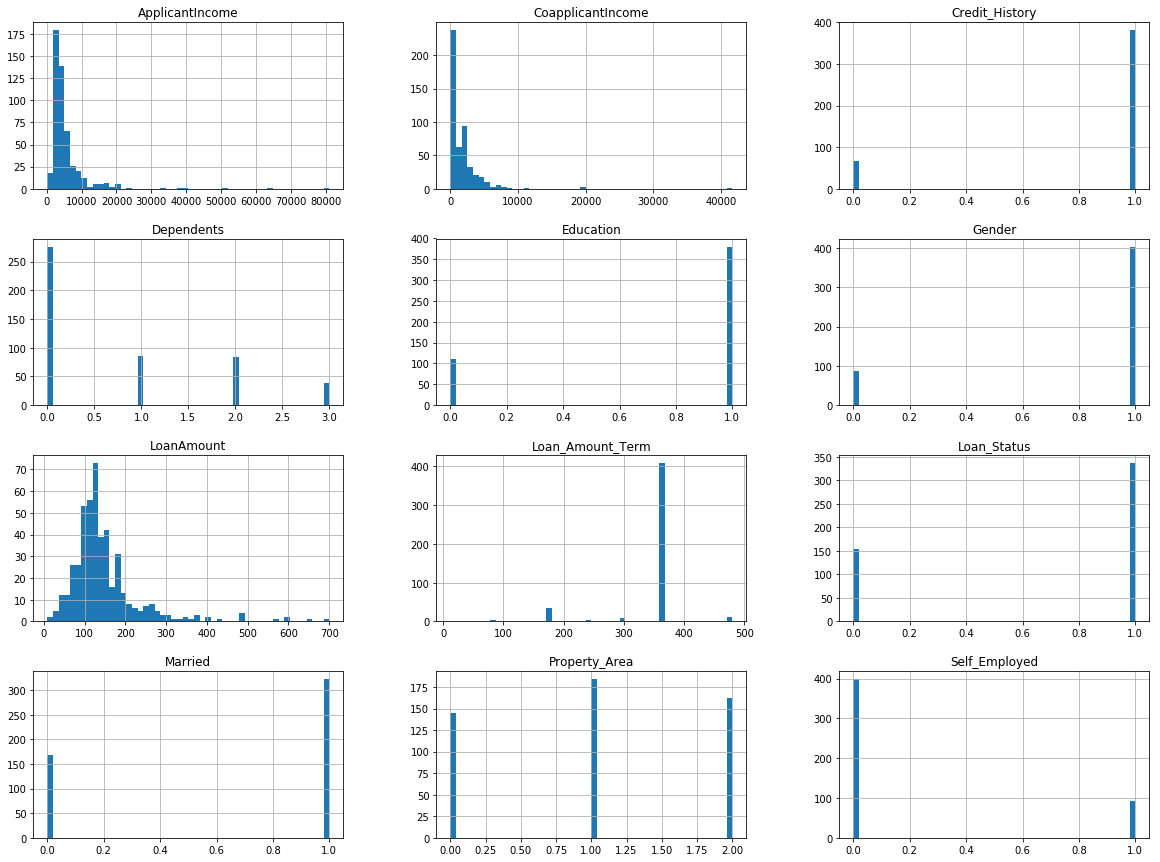

In [944]:
# The categorical attributes are converted into numercical types for visualisation purpose, and may be useful
# in a later stage.
df_train_num = df_train.copy()
df_train_num["Gender"]        = df_train_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_train_num["Married"]       = df_train_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_train_num["Dependents"]    = df_train_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_train_num["Education"]     = df_train_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_train_num["Self_Employed"] = df_train_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_train_num["Property_Area"] = df_train_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_train_num["Loan_Status"]   = df_train_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_train_num.hist(bins = 50, figsize = (20, 15), layout = (4, 3));

#### Visualisation of Test Set

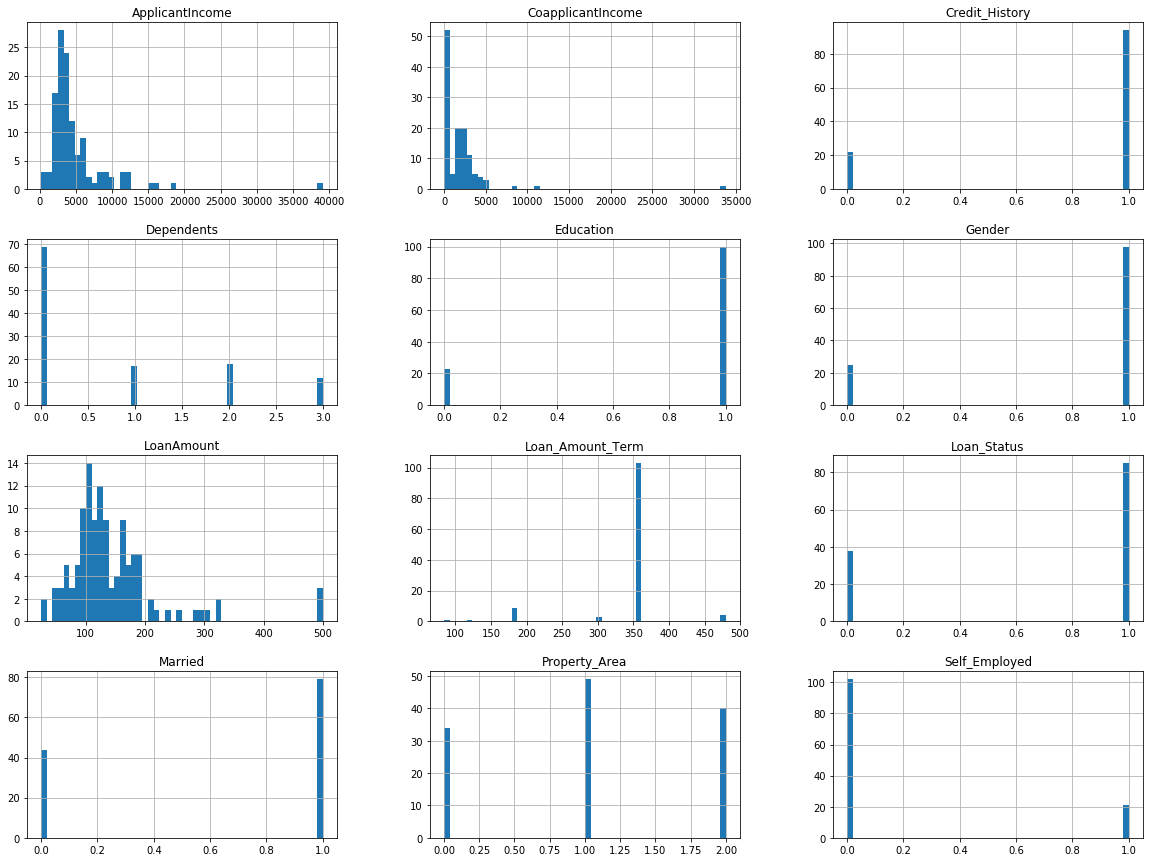

In [945]:
df_test_num = df_test.copy()
df_test_num["Gender"]        = df_test_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_test_num["Married"]       = df_test_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_test_num["Dependents"]    = df_test_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_test_num["Education"]     = df_test_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_test_num["Self_Employed"] = df_test_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_test_num["Property_Area"] = df_test_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_test_num["Loan_Status"]   = df_test_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_test_num.hist(bins = 50, figsize = (20, 15), layout = (4, 3));

In [946]:
print("The categorical attributes are converted into numercical types for visualisation purpose, and may be useful")
print("in a later stage.")
print("Feathure scaling should be considered due to the very different scales among attributes and the havey tails")
print("in several histograms.")

The categorical attributes are converted into numercical types for visualisation purpose, and may be useful
in a later stage.
Feathure scaling should be considered due to the very different scales among attributes and the havey tails
in several histograms.


#### Initial Correlations Check (numerical)

In [947]:
correlation_matrix_train = df_train_num.corr()
correlation_matrix_train["Loan_Status"].sort_values(ascending = False)

Loan_Status          1.000000
Credit_History       0.537914
Education            0.085899
Married              0.064618
Property_Area        0.035185
Dependents           0.025777
Loan_Amount_Term     0.025708
LoanAmount          -0.006558
Self_Employed       -0.009309
Gender              -0.014798
ApplicantIncome     -0.015775
CoapplicantIncome   -0.047198
Name: Loan_Status, dtype: float64

In [948]:
correlation_matrix_test = df_test_num.corr()
correlation_matrix_test["Loan_Status"].sort_values(ascending = False)

Loan_Status          1.000000
Credit_History       0.646258
Married              0.198463
Gender               0.143259
Education            0.085485
Self_Employed        0.069573
ApplicantIncome      0.060873
Property_Area        0.019404
Dependents          -0.070366
CoapplicantIncome   -0.100207
LoanAmount          -0.169022
Loan_Amount_Term    -0.217106
Name: Loan_Status, dtype: float64

#### Correlations Check (1-Hot)

# 3. Data Preparation

### 3.1 Missing Data Handling

In [949]:
print("There are " + str(len(df_train[df_train.isnull().any(axis = 1)])) + " out of " + str(len(df_train)) + " instances in training set with missing data.")
print("There are " + str(len(df_test[df_test.isnull().any(axis = 1)])) + " out of " + str(len(df_test)) + " instances in test set with missing data.")
print("Since most of the attributes (except for Loan_ID) contain important information in deciding whether the application")
print("can be approved, and most of the attributes are binary or categorical, filling with mean or zero may not be a good");
print("idea. So, the instances with incomplete information are removed from both train and test sets first.")

There are 110 out of 491 instances in training set with missing data.
There are 24 out of 123 instances in test set with missing data.
Since most of the attributes (except for Loan_ID) contain important information in deciding whether the application
can be approved, and most of the attributes are binary or categorical, filling with mean or zero may not be a good
idea. So, the instances with incomplete information are removed from both train and test sets first.


In [950]:
df_train = df_train.dropna()
df_test  = df_test.dropna()
df_train = df_train.reset_index(drop = True)
df_test  = df_test.reset_index(drop = True)
print("There are " + str(len(df_train)) + " instances left in train set after removing missing-data instances;")
print("There are " + str(len(df_test))  + " instances left in test set after removing missing-data instances.")

There are 381 instances left in train set after removing missing-data instances;
There are 99 instances left in test set after removing missing-data instances.


### 3.2 Outliers Handling

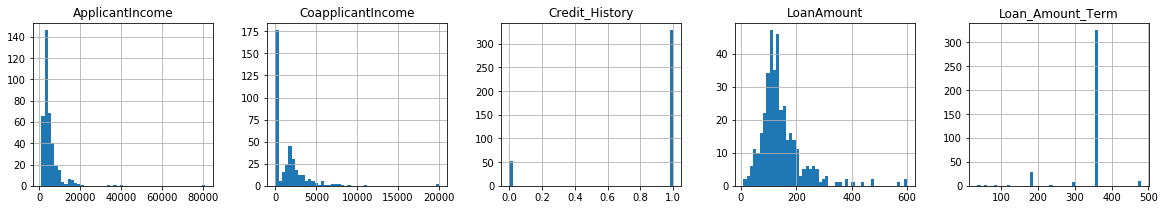

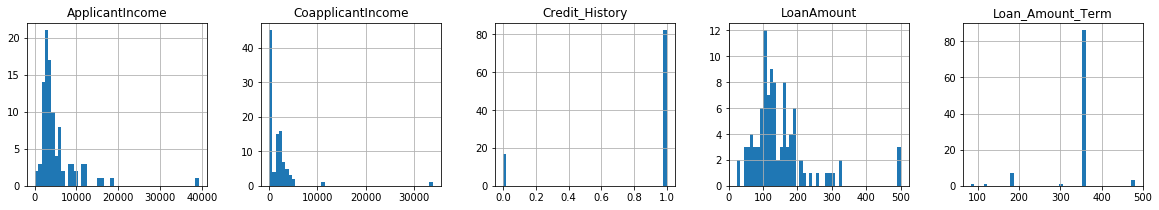

In [951]:
df_train.hist(bins = 50, figsize = (20, 3), layout = (1, 5));
df_test.hist(bins = 50,  figsize = (20, 3), layout = (1, 5));

In [952]:
print("There are several outliers in Applicant_Income and Coapplicant_Income in both train and test set,")
print("especially the instance with Applicant_Income of 80,000 in training set, which is much larger than the")
print("largest Applicant_Income in test set, which could be considered to remove.")

There are several outliers in Applicant_Income and Coapplicant_Income in both train and test set,
especially the instance with Applicant_Income of 80,000 in training set, which is much larger than the
largest Applicant_Income in test set, which could be considered to remove.


In [953]:
df_train[df_train.ApplicantIncome > 80000]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
94,LP002317,Male,Yes,3+,Graduate,No,81000,0.0,360.0,360.0,0.0,Rural,N


In [954]:
print("Ths CoapplicantIncome of this instance is 0, so the total family income is 81,000.")
print("Looking into the test set, there are also 2 outliers in ApplicantIncome and CoapplicantIncome, and the sum of the")
print("two incomes are comparable to 81,000. So, we'd better confirm whether the 2 outliers in test set come from the same")
print("family.")

Ths CoapplicantIncome of this instance is 0, so the total family income is 81,000.
Looking into the test set, there are also 2 outliers in ApplicantIncome and CoapplicantIncome, and the sum of the
two incomes are comparable to 81,000. So, we'd better confirm whether the 2 outliers in test set come from the same
family.


In [955]:
df_test[df_test.ApplicantIncome > 30000]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
23,LP001640,Male,Yes,0,Graduate,Yes,39147,4750.0,120.0,360.0,1.0,Semiurban,Y


In [956]:
df_test[df_test.CoapplicantIncome > 30000]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
19,LP002893,Male,No,0,Graduate,No,1836,33837.0,90.0,360.0,1.0,Urban,N


In [957]:
print("However, they are not from same family. So, the outlier in train set can be removed.")

However, they are not from same family. So, the outlier in train set can be removed.


In [958]:
df_train = df_train[df_train.ApplicantIncome < 80000]
df_train = df_train.reset_index(drop = True)
print("There are " + str(len(df_train)) + " instances left in train set after removing outlier.")

There are 380 instances left in train set after removing outlier.


### 3.3 Categorical Attributes Handling

There are 2 ways of handling the categorical attributes: one is to represent the information using number, such as using number 0 to represent "No", "Not Graduate", "N", "Female", "Rural", and number 1 to represent "Yes", "Graduate", "Y", "Male", "Urban", 0.5 to represent "Semiurban" (the attribute can be interpreted as urbanisation); the other way is to use 1-hot encoder.

#### 3.2.1 Categotical to Numeric

In [959]:
df_train_num = df_train.copy()
df_train_num["Gender"]        = df_train_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_train_num["Married"]       = df_train_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_train_num["Dependents"]    = df_train_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_train_num["Education"]     = df_train_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_train_num["Self_Employed"] = df_train_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_train_num["Property_Area"] = df_train_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_train_num["Loan_Status"]   = df_train_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_train_num.shape

(380, 13)

In [960]:
df_test_num = df_test.copy()
df_test_num["Gender"]        = df_test_num.Gender.apply(lambda x:        0 if x == "Female"       else 1)
df_test_num["Married"]       = df_test_num.Married.apply(lambda x:       0 if x == "No"           else 1)
df_test_num["Dependents"]    = df_test_num.Dependents.apply(lambda x:    dependents_to_num(x))
df_test_num["Education"]     = df_test_num.Education.apply(lambda x:     0 if x == "Not Graduate" else 1)
df_test_num["Self_Employed"] = df_test_num.Self_Employed.apply(lambda x: 0 if x == "No"           else 1)
df_test_num["Property_Area"] = df_test_num.Property_Area.apply(lambda x: property_area_to_num(x))
df_test_num["Loan_Status"]   = df_test_num.Loan_Status.apply(lambda x:   0 if x == "N"            else 1)
df_test_num.shape

(99, 13)

In [961]:
correlation_matrix_train = df_test_num.corr()
correlation_matrix_train["Loan_Status"].sort_values(ascending = False)

Loan_Status          1.000000
Credit_History       0.632248
Married              0.186917
Gender               0.125154
ApplicantIncome      0.054245
Education            0.031083
Property_Area       -0.002635
Self_Employed       -0.003944
Dependents          -0.054536
CoapplicantIncome   -0.164685
LoanAmount          -0.173927
Loan_Amount_Term    -0.178704
Name: Loan_Status, dtype: float64

#### 3.2.2 1-Hot

In [962]:
df_train_cat = df_train[["Gender", "Married", "Education", "Self_Employed", "Credit_History", "Property_Area", "Dependents", "Loan_Amount_Term"]]
# df_train_cat = df_train[["Gender", "Married", "Education", "Self_Employed", "Credit_History", "Property_Area", "Dependents"]]
df_train_cat.head(10)

,Gender,Married,Education,Self_Employed,Credit_History,Property_Area,Dependents,Loan_Amount_Term
0,Male,No,Graduate,No,1.0,Urban,0,360.0
1,Male,Yes,Graduate,No,1.0,Semiurban,1,360.0
2,Male,Yes,Graduate,No,0.0,Rural,2,360.0
3,Male,Yes,Not Graduate,No,0.0,Rural,1,180.0
4,Male,Yes,Graduate,No,1.0,Semiurban,0,360.0
5,Male,Yes,Not Graduate,Yes,1.0,Semiurban,2,360.0
6,Male,Yes,Graduate,No,1.0,Semiurban,0,180.0
7,Female,No,Graduate,Yes,1.0,Rural,0,360.0
8,Male,Yes,Graduate,No,1.0,Semiurban,0,360.0
9,Male,No,Graduate,No,1.0,Semiurban,1,360.0


In [963]:
cat_encoder    = OneHotEncoder(sparse=False)
train_cat_1hot = cat_encoder.fit_transform(df_train_cat)
print(type(train_cat_1hot))
print(train_cat_1hot.shape)
print(cat_encoder.categories_)

<class 'numpy.ndarray'>
(380, 26)
[array(['Female', 'Male'], dtype=object), array(['No', 'Yes'], dtype=object), array(['Graduate', 'Not Graduate'], dtype=object), array(['No', 'Yes'], dtype=object), array([0.0, 1.0], dtype=object), array(['Rural', 'Semiurban', 'Urban'], dtype=object), array(['0', '1', '2', '3+'], dtype=object), array([36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0],
      dtype=object)]


In [964]:
#df_train_1hot = pd.DataFrame(train_cat_1hot, columns = list(housing.columns)+["rooms_per_household", "population_per_household"])
df_train_1hot = df_train[["Loan_ID", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Status"]]
print(df_train_1hot.shape)
print(train_cat_1hot.shape)
df_train_1hot = df_train_1hot.join(
    pd.DataFrame(train_cat_1hot, columns = ["Female",             "Male", 
                                            "Not_Married",        "Married",
                                            "Graduate",           "Not_Graduate",
                                            "Not_Self_Employed",  "Self_Employed",
                                            "No_Credit_History",  "With_Credit_History",
                                            "Rural", "Semiurban", "Urban",
                                            "0_Dependent", "1_Dependent", "2_Dependents", "3+_Dependents",
                                            "36_Terms",    "60_Terms",    "84_Terms",     "120_Terms",   "180_Terms", 
                                            "240_Terms",   "300_Terms",   "360_Terms",    "480_Terms"]))

df_train_1hot["Loan_Status_1hot"] = df_train_1hot.Loan_Status.apply(lambda x: 1 if x == "Y" else 0)
#df_train_1hot.tail(10)
correlation_matrix_train = df_train_1hot.corr()
correlation_matrix_train["Loan_Status_1hot"].sort_values(ascending = False)

(380, 5)
(380, 26)


Loan_Status_1hot       1.000000
With_Credit_History    0.497443
Semiurban              0.173704
360_Terms              0.140846
Married                0.096213
Graduate               0.079741
2_Dependents           0.071087
Male                   0.050428
120_Terms              0.048516
60_Terms               0.048516
Not_Self_Employed      0.044126
3+_Dependents          0.026148
CoapplicantIncome     -0.005218
ApplicantIncome       -0.017680
1_Dependent           -0.019722
84_Terms              -0.030271
240_Terms             -0.030271
LoanAmount            -0.032891
Self_Employed         -0.044126
180_Terms             -0.044468
Female                -0.050428
0_Dependent           -0.055237
Urban                 -0.061966
Not_Graduate          -0.079741
Not_Married           -0.096213
300_Terms             -0.100737
36_Terms              -0.109057
480_Terms             -0.121050
Rural                 -0.123154
No_Credit_History     -0.497443
Name: Loan_Status_1hot, dtype: float64

### 3.4 Feature Selection & Egineering

There are several numerical attributes which could be selected for feature engineering, they are:
    1. Number of Dependents
    2. Applicant Income
    3. Co-applicant Income
    4. Loan Amount
    5. Loan Term

There are some new feature could be generated which could affect the application result:
    1. Family Income            = Applicant Income + Co-applicant Income
    2. Individual Income        = (Applicant Income + Co-applicant Income) / (2 + Number of Dependents)
    3. Loan Amount/Income Ratio = Loan Amount / (Applicant Income + Co-applicant Income)
    4. Loan Term/Income Ratio   = Loan Term / (Applicant Income + Co-applicant Income)
    5. ...

In [965]:
# Set Loan_ID as index of the 2 DataFrames
df_train_num.set_index('Loan_ID', inplace = True)
df_test_num.set_index('Loan_ID', inplace = True)

# Combine the train set and test set first, to evaluate the coorelation between the target Loan_Status and new features
df_num = df_train_num.append(df_test_num)#, ignore_index = True)

# Adding new features
df_num["Family_Income"]       = df_num.ApplicantIncome   + df_num.CoapplicantIncome
df_num["Individual_Income"]   = df_num["Family_Income"]  / (2 + df_num.Dependents)
df_num["Loan_Income_Ratio"]   = df_num.LoanAmount        / df_num["Family_Income"]
df_num["Loan_Term_Ratio"]     = df_num.LoanAmount        / df_num.Loan_Amount_Term
#df_num["*Inteseting_Ratio"]     = df_num.CoapplicantIncome / df_num.Dependents
#df_num["*Inteseting_Ratio+1"]   = df_num.CoapplicantIncome / (df_num.Dependents + 1)
#df_num["*Inteseting_Ratio+2"]   = df_num.CoapplicantIncome / (df_num.Dependents + 2)
df_num["*multi"]              = df_num.LoanAmount        * df_num.Loan_Amount_Term
df_num["*div"]                = df_num.LoanAmount        / df_num.Loan_Amount_Term
print("After adding 6 features, the shape of df_num becomes " + str(df_num.shape))

correlation_matrix = df_num.corr()
correlation_matrix["Loan_Status"].sort_values(ascending = False)

After adding 6 features, the shape of df_num becomes (479, 18)


Loan_Status          1.000000
Credit_History       0.526276
Married              0.114960
Education            0.070194
Gender               0.066135
Dependents           0.042555
Property_Area        0.027350
ApplicantIncome     -0.001752
Loan_Amount_Term    -0.006953
Family_Income       -0.028773
Self_Employed       -0.036054
CoapplicantIncome   -0.051049
Individual_Income   -0.054745
LoanAmount          -0.064013
*multi              -0.067958
Loan_Term_Ratio     -0.072035
*div                -0.072035
Loan_Income_Ratio   -0.091020
Name: Loan_Status, dtype: float64

In [966]:
# After confiriming what new features to be added, now add them to train & test sets seperately

for df in [df_train_num, df_test_num]:
    # Adding new features
    df["Family_Income"]       = df.ApplicantIncome   + df.CoapplicantIncome
    df["Individual_Income"]   = df["Family_Income"]  / (2 + df.Dependents)
    df["Loan_Income_Ratio"]   = df.LoanAmount        / df["Family_Income"]
    df["Loan_Term_Ratio"]     = df.LoanAmount        / df.Loan_Amount_Term
    df["*multi"]              = df.LoanAmount        * df.Loan_Amount_Term
    df["*div"]                = df.LoanAmount        / df.Loan_Amount_Term
    
print("After adding 6 features, the shape of df_train_num becomes " + str(df_train_num.shape))
print("After adding 6 features, the shape of df_test_num becomes "  + str(df_test_num.shape))

After adding 6 features, the shape of df_train_num becomes (380, 18)
After adding 6 features, the shape of df_test_num becomes (99, 18)


In [968]:
# seperate the data and label for train & test set
X_train_num = df_train_num.drop("Loan_Status", axis = 1) 
y_train_num = df_train_num["Loan_Status"].copy()
X_test_num  = df_test_num.drop("Loan_Status",  axis = 1) 
y_test_num  = df_test_num["Loan_Status"].copy()

In [918]:
num_pipeline = Pipeline([
        ('std_scaler',    MinMaxScaler()),
        #('std_scaler',    StandardScaler()),
    ])

X_train_num_tr = num_pipeline.fit_transform(X_train_num)
print(X_train_num_tr.shape) # (380, 17)
X_train_num_scaled = pd.DataFrame(X_train_num_tr, index = X_train_num.index, columns = X_train_num.columns)
X_train_num_scaled.head(3)

(380, 17)


/Users/MacPro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Family_Income,Individual_Income,Loan_Income_Ratio,Loan_Term_Ratio,*multi,*div
Loan_ID,,,,,,,,,,,,,,,,,
LP001535,1.0,0.0,0.000000,1.0,0.0,0.057796,0.0000,0.069374,0.72973,1.0,1.0,0.046995,0.088441,0.154959,0.026606,0.074593,0.026606
LP001792,1.0,1.0,0.333333,1.0,0.0,0.059360,0.0000,0.147208,0.72973,1.0,0.5,0.048577,0.044970,0.325528,0.056457,0.151991,0.056457
LP002443,1.0,1.0,0.666667,1.0,0.0,0.060002,0.0855,0.238579,0.72973,0.0,0.0,0.093576,0.058086,0.334860,0.091499,0.242849,0.091499


In [919]:
X_test_num_tr = num_pipeline.fit_transform(X_test_num)
print(X_test_num_tr.shape) # (380, 17)
X_test_num_scaled = pd.DataFrame(X_test_num_tr, index = X_test_num.index, columns = X_test_num.columns)
X_test_num_scaled.head(3)

(99, 17)


/Users/MacPro/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Family_Income,Individual_Income,Loan_Income_Ratio,Loan_Term_Ratio,*multi,*div
Loan_ID,,,,,,,,,,,,,,,,,
LP001528,1.0,0.0,0.0,1.0,0.0,0.157115,0.00000,0.195789,0.69697,0.0,0.0,0.103154,0.120134,0.243987,0.187234,0.223051,0.187234
LP002804,0.0,1.0,0.0,1.0,0.0,0.103341,0.06815,0.330526,0.69697,1.0,0.5,0.108136,0.125022,0.382826,0.323404,0.353220,0.323404
LP002945,1.0,1.0,0.0,1.0,1.0,0.251635,0.00000,0.326316,0.69697,1.0,0.0,0.191027,0.206343,0.233015,0.319149,0.349153,0.319149


In [915]:
# Try Linear Regression on X_train_num_scaled
linear_regression = LinearRegression()
linear_regression.fit(X_train_num_scaled, y_train_num)
pred_train_num    = linear_regression.predict(X_train_num_scaled)
linear_regression_mse  = mean_squared_error(y_train_num, pred_train_num)
linear_regression_rmse = np.sqrt(linear_regression_mse)
linear_regression_rmse

0.3889220900745009

In [916]:
# 
decision_tree_regression = DecisionTreeRegressor(random_state = 42)
decision_tree_regression.fit(X_train_num_scaled, y_train_num)
pred_train_num = decision_tree_regression.predict(X_train_num_scaled)
decision_tree_mse            = mean_squared_error(y_train_num, pred_train_num)
decision_tree_rmse           = np.sqrt(tree_mse)
decision_tree_rmse

0.0

In [978]:
#KNN = KNeighborsClassifier(1)
#KNN.fit(X_train_num_scaled, y_train_num)
#y_train_pred    = KNN.predict(X_train_num_scaled)
#y_test_pred     = KNN.predict(X_test_num_scaled)
#print(y_train_num[0])
#print(y_train_pred[0])


#accuracy_train  = accuracy_score(y_train_num, y_train_pred) 
#accuracy_test   = accuracy_score(y_test_num,  y_test_pred) 
#print('Train Accuracy:  {}'.format(accuracy_train)) 
#print('Test  Accuracy:  {}'.format(accuracy_test)) 
#print('Accuracy in this case is the ratio between the number of images which are classified correctly')
#print('and the total images number, which can be used to evaluate the performance of a classifier.')
#print()

KNN_model = KNeighborsClassifier()

parameters_range = {'n_neighbors': range(1, 11, 1),
                    'weights':     ['uniform', 'distance'],
                    'algorithm':   ['ball_tree', 'kd_tree', 'brute', 'auto'],
                    'leaf_size':   range(1,100,1),
                    'p':           [1, 2]
                   }
grid = RandomizedSearchCV(KNN_model, 
                          parameters_range, 
                          cv      = 5,
                          scoring = 'accuracy',
                          n_iter  = 15840,
                          n_jobs  = -1)
grid.fit(X_train_num_scaled, y_train_num)
best_params    = grid.best_params_
best_estimator = grid.best_estimator_
best_score     = grid.best_score_
print("Best Parameters:")
print(best_params)
print("Best Score:")
print(best_score)

y_train_pred   = grid.best_estimator_.predict(X_train_pca)
y_test_pred    = grid.best_estimator_.predict(X_test_pca)
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test  = accuracy_score(y_test,  y_test_pred)
print("The accuracy of train set is: " + str(accuracy_train))
print("The accuracy of test set is:  " + str(accuracy_test))

print('Scanning k from 1 to 10:')
for neighbour in range(1, 11):    
    KNN = KNeighborsClassifier(neighbour)
    KNN.fit(X_train_num_scaled, y_train_num)
    y_train_pred    = KNN.predict(X_train_num_scaled)
    y_test_pred     = KNN.predict(X_test_num_scaled)
    accuracy_train  = accuracy_score(y_train_num, y_train_pred) 
    accuracy_test   = accuracy_score(y_test_num,  y_test_pred) 
    print('k = {}, Train Accuracy:  {}'.format(neighbour, accuracy_train)) 
    print('k = {}, Test  Accuracy:  {}'.format(neighbour, accuracy_test)) 
    plt.scatter(neighbour, accuracy_train)
    plt.scatter(neighbour, accuracy_test)

KeyboardInterrupt: 

### 3.5 Separation of Predictors and Labels

In [36]:
Xs_train = df_train.drop("Loan_Status", axis = 1)
y_train  = df_train["Loan_Status"].copy()
Xs_train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban
1,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban
2,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural


In [37]:
y_train.head(3)

0    Y
1    Y
2    N
Name: Loan_Status, dtype: object

In [38]:
print("loanamount 和 loanterm 需要补0")

loanamount 和 loanterm 需要补0


#### Experimenting with Attribute Combinations

In [39]:
df_train_num.dropna(inplace = True)
df_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 490
Data columns (total 13 columns):
Loan_ID              380 non-null object
Gender               380 non-null int64
Married              380 non-null int64
Dependents           380 non-null int64
Education            380 non-null int64
Self_Employed        380 non-null int64
ApplicantIncome      380 non-null int64
CoapplicantIncome    380 non-null float64
LoanAmount           380 non-null float64
Loan_Amount_Term     380 non-null float64
Credit_History       380 non-null float64
Property_Area        380 non-null int64
Loan_Status          380 non-null int64
dtypes: float64(4), int64(8), object(1)
memory usage: 41.6+ KB


In [40]:
df_train_num.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001535,1,0,0,1,0,3254,0.0,50.0,360.0,1.0,2,1
1,LP001792,1,1,1,1,0,3315,0.0,96.0,360.0,1.0,1,1
2,LP002443,1,1,2,1,0,3340,1710.0,150.0,360.0,0.0,0,0
3,LP002517,1,1,1,0,0,2653,1500.0,113.0,180.0,0.0,0,0
4,LP001894,1,1,0,1,0,2620,2223.0,150.0,360.0,1.0,1,1


In [41]:
df_train_num["Family_Income"]               = df_train_num["ApplicantIncome"] + df_train_num["CoapplicantIncome"]
df_train_num["Family_Income_per_Dependent"] = df_train_num["Family_Income"]   / df_train_num["Dependents"]
df_train_num["Family_Income_per_Person"]    = df_train_num["Family_Income"]   / (df_train_num["Dependents"] + 2)
#df_train_num["population_per_household"] = df_train_num["population"]     / df_train_num["households"]
correlation_matrix_train = df_train_num.corr()
correlation_matrix_train["Loan_Status"].sort_values(ascending = False)

Loan_Status                    1.000000
Credit_History                 0.497443
Married                        0.096213
Education                      0.079741
Dependents                     0.068522
Gender                         0.050428
Loan_Amount_Term               0.035091
Property_Area                  0.034900
CoapplicantIncome             -0.005218
ApplicantIncome               -0.017680
Family_Income                 -0.019307
LoanAmount                    -0.032891
Self_Employed                 -0.044126
Family_Income_per_Dependent   -0.046804
Family_Income_per_Person      -0.070423
Name: Loan_Status, dtype: float64

In [42]:
df_test_num["Family_Income"]               = df_test_num["ApplicantIncome"] + df_test_num["CoapplicantIncome"]
df_test_num["Family_Income_per_Dependent"] = df_test_num["Family_Income"]   / df_test_num["Dependents"]
df_test_num["Family_Income_per_Person"]    = df_test_num["Family_Income"]   / (df_test_num["Dependents"] + 2)
#df_train_num["population_per_household"] = df_train_num["population"]     / df_train_num["households"]
correlation_matrix_test = df_test_num.corr()
correlation_matrix_test["Loan_Status"].sort_values(ascending = False)

Loan_Status                    1.000000
Credit_History                 0.632248
Married                        0.186917
Gender                         0.125154
ApplicantIncome                0.054245
Education                      0.031083
Property_Area                 -0.002635
Self_Employed                 -0.003944
Family_Income_per_Person      -0.020753
Dependents                    -0.054536
Family_Income                 -0.058724
Family_Income_per_Dependent   -0.146347
CoapplicantIncome             -0.164685
LoanAmount                    -0.173927
Loan_Amount_Term              -0.178704
Name: Loan_Status, dtype: float64

In [43]:
# 组合数字, 等会组合boolean!!!
df_train_num_feature_comb = df_train_num.copy()
df_train_num_feature_comb.drop("Loan_ID",        axis = 1, inplace = True)
df_train_num_feature_comb.drop("Credit_History", axis = 1, inplace = True)
df_train_num_feature_comb.drop("Education",      axis = 1, inplace = True)
df_train_num_feature_comb.drop("Married",        axis = 1, inplace = True)
df_train_num_feature_comb.drop("Property_Area",  axis = 1, inplace = True)
df_train_num_feature_comb.drop("Self_Employed",  axis = 1, inplace = True)
df_train_num_feature_comb.drop("Gender",         axis = 1, inplace = True)

In [44]:
df_train_num_feature_comb.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Family_Income,Family_Income_per_Dependent,Family_Income_per_Person
0,0,3254,0.0,50.0,360.0,1,3254.0,inf,1627.000000
1,1,3315,0.0,96.0,360.0,1,3315.0,3315.000000,1105.000000
2,2,3340,1710.0,150.0,360.0,0,5050.0,2525.000000,1262.500000
3,1,2653,1500.0,113.0,180.0,0,4153.0,4153.000000,1384.333333
4,0,2620,2223.0,150.0,360.0,1,4843.0,inf,2421.500000


In [45]:
"Dependents", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"

('Dependents',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term')

In [46]:
print("评论")

评论


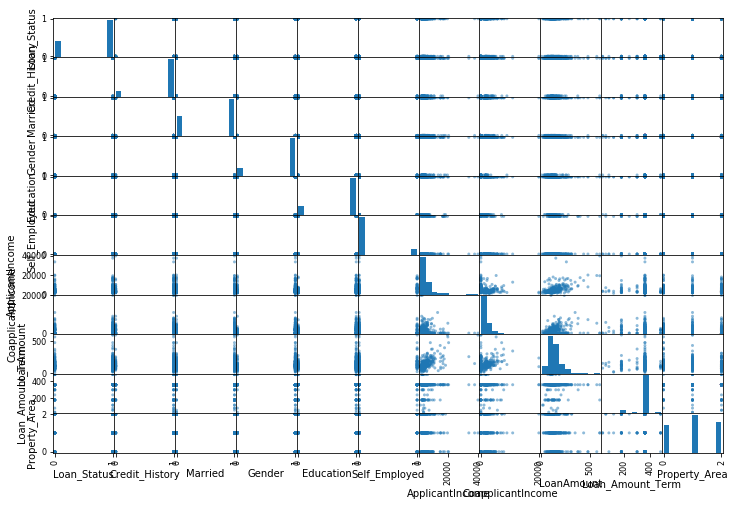

In [47]:
attributes = ["Loan_Status", "Credit_History", "Married", "Gender", "Education", "Self_Employed","ApplicantIncome", 
              "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term",  "Property_Area", ]
scatter_matrix(df_train_num[attributes], figsize=(12, 8));

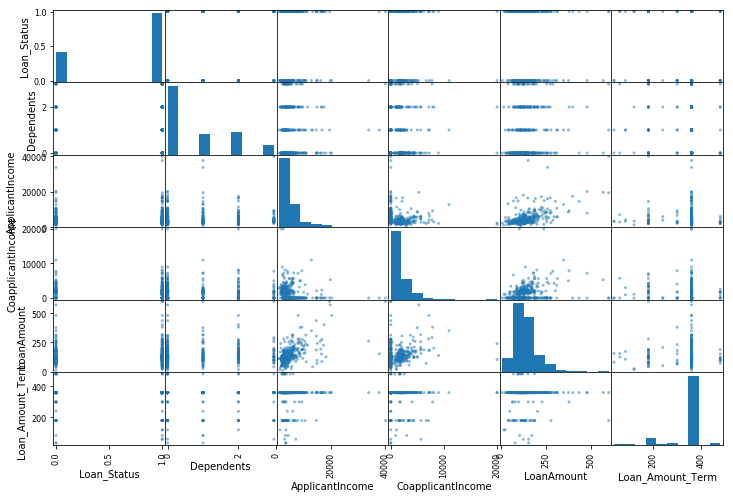

In [48]:
attributes = ["Loan_Status", "Dependents", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
scatter_matrix(df_train_num[attributes], figsize=(12, 8));

In [49]:
print("两个人薪水可以相加")

两个人薪水可以相加


In [50]:
print("Missing Data")
print("Categorical Data")

Missing Data
Categorical Data


## 2. Visualisation